Introduction

The purpose of this project is to analyze credit card data in order to identify trends that may cause low/high balances. To achieve this, we will be using clustering to seperate people into groups based on their card usage frequency, and then using linear regression to identify whether these groups tend to rack up high balances or not, as well as other behaviours and trends.

____________________________________________________________________________________________________________________________________________________

Pip Installs & Imports

In [19]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

____________________________________________________________________________________________________________________________________________________

Model Intialization & Pre-Processing

In [21]:
df = pd.read_csv("CC GENERAL.csv")
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


In [22]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Interestingly, when observing our columns, we see "MINIMUM_PAYMENTS" and "CREDIT_LIMIT" are the only columns with nulls. We fill missing "MINIMUM_PAYMENTS" with the median value, since this column tends to be right-skewed data (mean is brought up by a few outliers). Imputation using median helps simulate realistic average behaviour by using a central point. As for the one null "CREDIT_LIMIT" column, we can drop that entry without any real consequence.

In [23]:
df["MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].median())
df = df.dropna(subset=["CREDIT_LIMIT"])
print(df.isnull().sum())

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


Let's start clustering now! We will be using K-Means since its use of Euclidean distance makes it more scalable and efficient than a brute-force-esque algorithm like agglomerative.

In [24]:
features = [
    "PURCHASES_FREQUENCY", 
    "ONEOFF_PURCHASES_FREQUENCY", 
    "PURCHASES_INSTALLMENTS_FREQUENCY", 
    "CASH_ADVANCE_FREQUENCY"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X_scaled)

df["Cluster"] = clusters

We initialize our clusters with a "K" of 5.

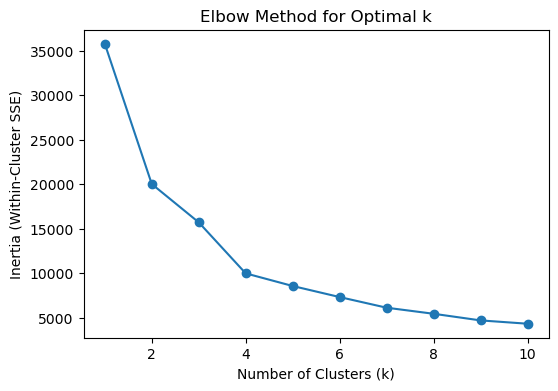

In [25]:
inertias = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

This visualization shows us the inertia values for our clusters. The lower the inertia, the closer to the center of each cluster our points are. In other words, we want to pick a value for "K" with low inertia so that our clusters are well-defined and don't overlap.

In [27]:
from sklearn.metrics import silhouette_score

for k in range(2, 8):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_test.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k}, Silhouette Score = {score:.4f}")


k = 2, Silhouette Score = 0.4360
k = 3, Silhouette Score = 0.4013
k = 4, Silhouette Score = 0.4585
k = 5, Silhouette Score = 0.4600
k = 6, Silhouette Score = 0.4215
k = 7, Silhouette Score = 0.4339


Silhouette score measures the separation quality of our clusters. The closer the score is to 1, the better our points match with their assigned cluster compared to other clusters.

Taking into account inertia and silhouette score, it seems that a value of "K" equal to 5 is optimal, so we will be sticking to 5 total clusters.

In [28]:
df.head(20)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,1
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12,2
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12,1
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12,0
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12,0


We want to rename our clusters into groups based on spending habits. Let's see the average spending frequency of each cluster so we can properly assign our group names.

In [29]:
cluster_means = df.groupby("Cluster")[[
    "PURCHASES_FREQUENCY",
    "ONEOFF_PURCHASES_FREQUENCY",
    "PURCHASES_INSTALLMENTS_FREQUENCY",
    "CASH_ADVANCE_FREQUENCY"
]].mean()

cluster_means

,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY
Cluster,,,,
0,0.192247,0.092408,0.097496,0.061357
1,0.895389,0.086332,0.848480,0.032399
2,0.901185,0.805488,0.486716,0.040645
3,0.059298,0.042444,0.015364,0.428895
4,0.804923,0.361141,0.624090,0.536713


Now we can properly assign cluster names:
- Cluster 0: Low Activity Users - Very little credit card utilization.
- Cluster 1: Structured Spenders – Tend to use credit for planned, large purchases made in installments (such as a TV). Less likely to impulse buy.
- Cluster 2: Impulse Shoppers - Very commonly make one-off purchases, with a moderate amount of installment spending as well.
- Cluster 3: Cash Advance Reliant - Tend to mainly use credit for short-term liquidity. This is very risky behaviour!
- Cluster 4: Heavy Spenders - High credit usage across the board.

In [30]:
cluster_names = {
    0: "Low Activity Users",
    1: "Structured Spenders",
    2: "Impulse Shoppers",
    3: "Cash Advance Reliant",
    4: "Heavy Spenders"
}

df["Cluster_Label"] = df["Cluster"].map(cluster_names)

df["Cluster_Label"].value_counts()

Cluster_Label
Low Activity Users      3358
Structured Spenders     2334
Cash Advance Reliant    1471
Impulse Shoppers        1334
Heavy Spenders           452
Name: count, dtype: int64

With our cluster names now assigned, we can see that low activity users are the larget group of credit card holders, with heavy spenders being the least common.

____________________________________________________________________________________________________________________________________________________

General Data by Cluster

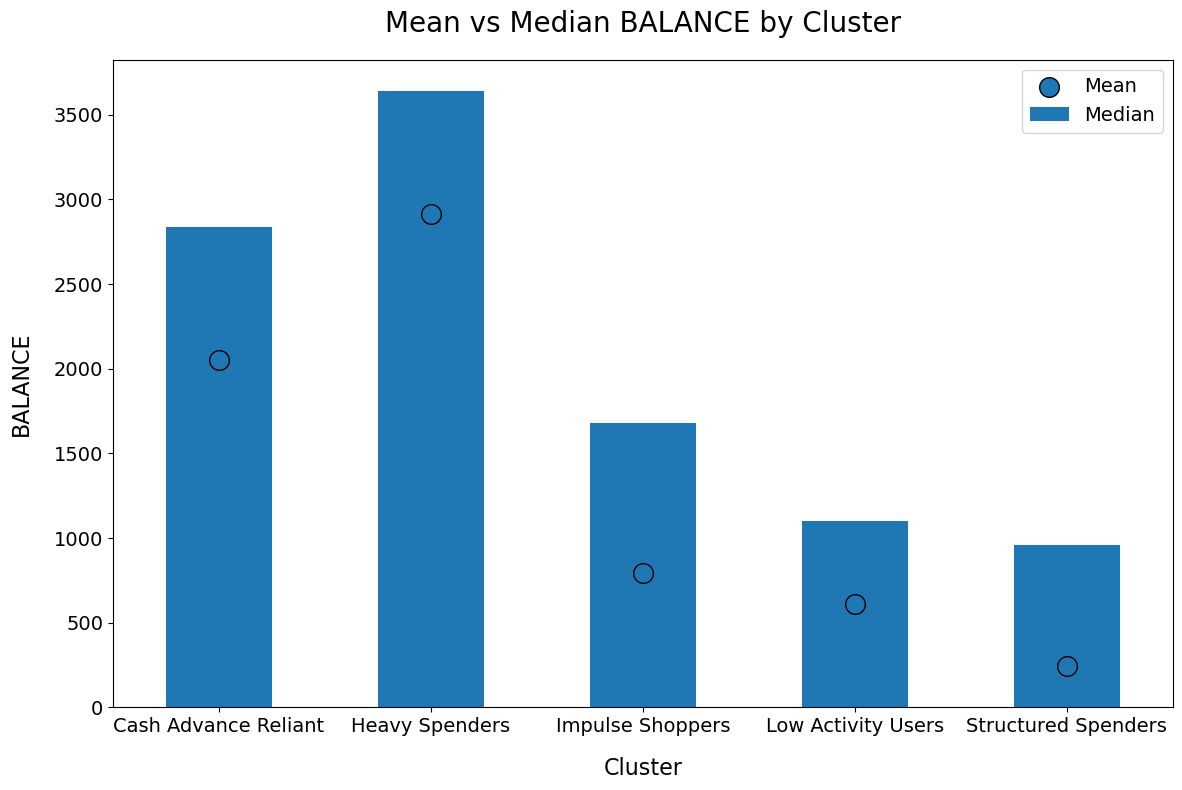

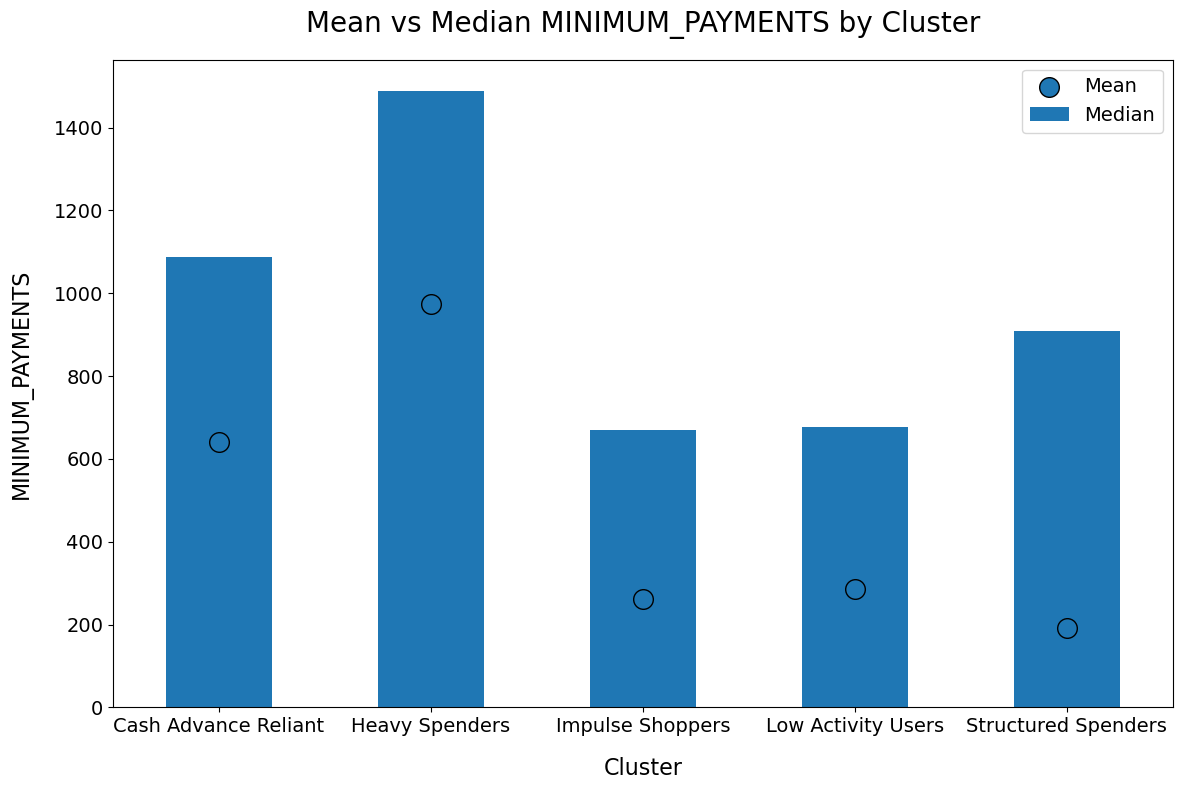

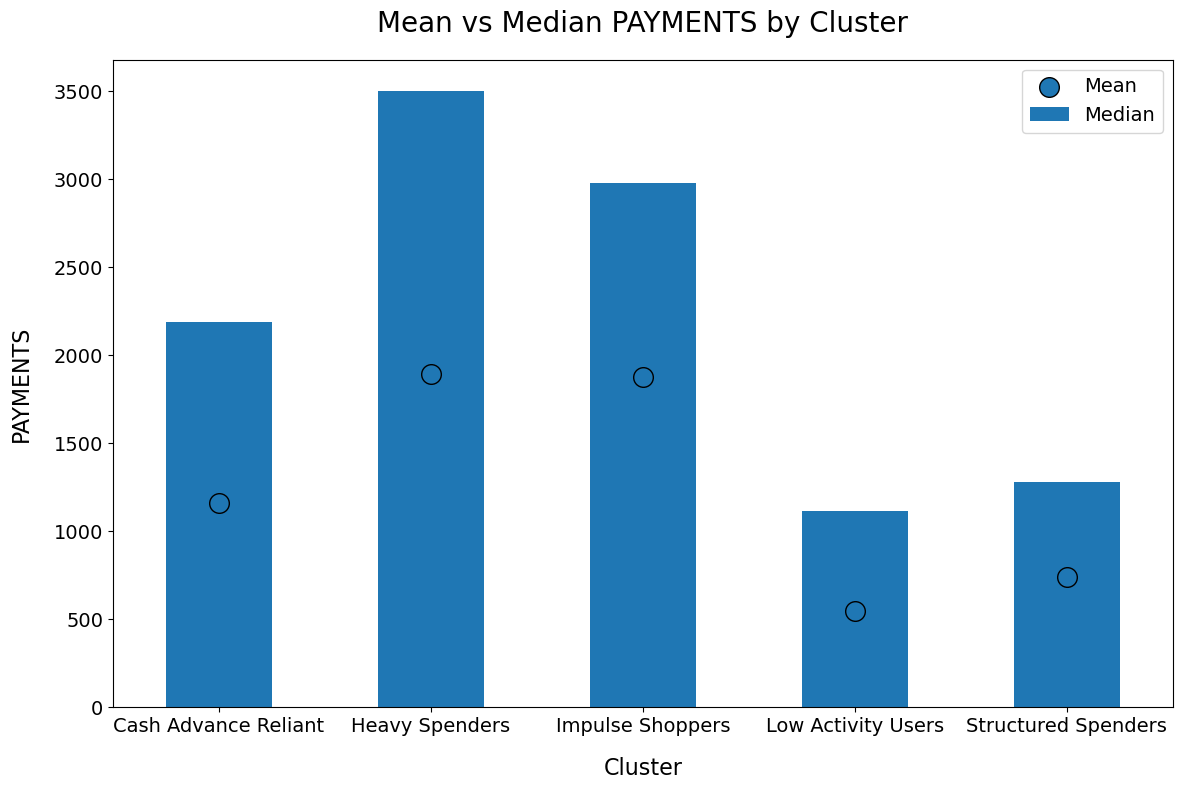

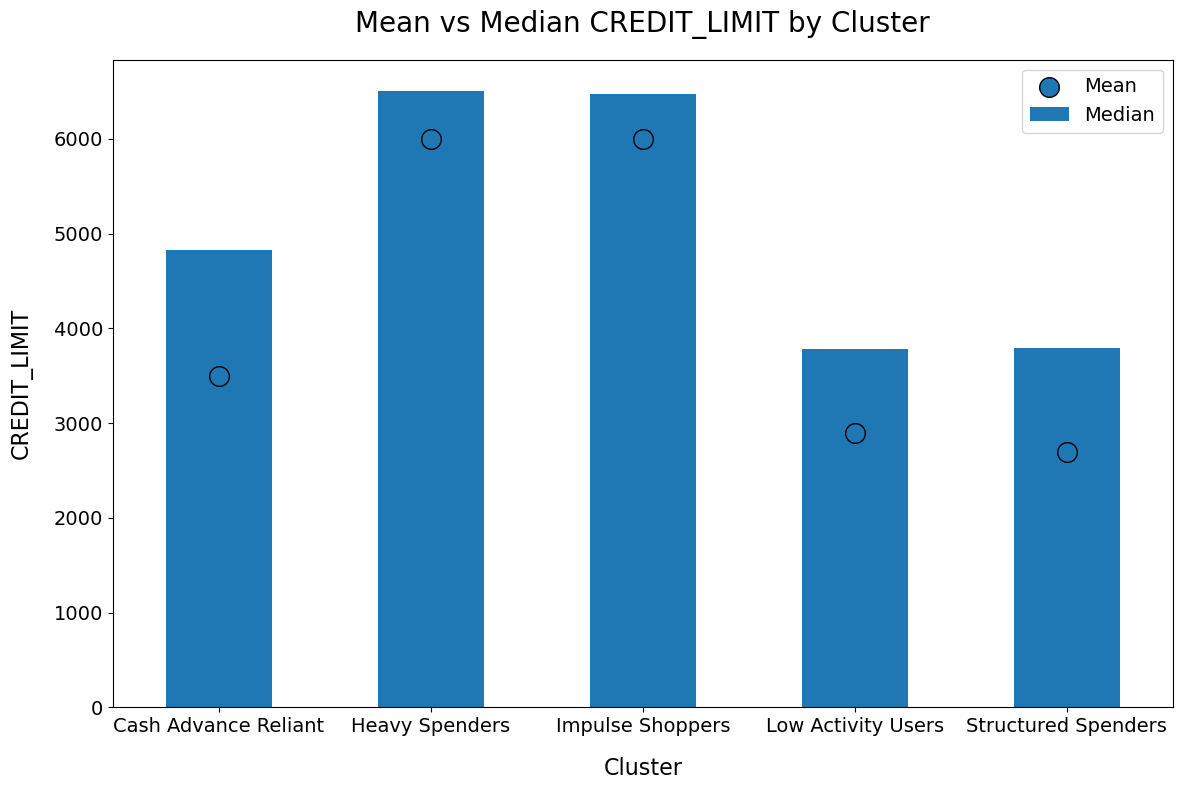

In [ ]:
financial_features = [
    "BALANCE",
    "MINIMUM_PAYMENTS",
    "PAYMENTS",
    "CREDIT_LIMIT",
]

cluster_means = df.groupby("Cluster_Label")[financial_features].mean()
cluster_medians = df.groupby("Cluster_Label")[financial_features].median()

for feature in financial_features:
    plt.figure(figsize=(12, 8))

    # Plot means (bars)
    ax = cluster_means[feature].plot(kind='bar', label='Mean')

    # Overlay medians (markers)
    median_values = cluster_medians[feature].values
    x_positions = np.arange(len(median_values))
    plt.scatter(x_positions, median_values, marker='o', s=200, edgecolor='black')

    # Labels and text formatting
    plt.title(f"Mean & Median {feature} by Cluster", fontsize=20, pad=20)
    plt.xlabel("Cluster", fontsize=16, labelpad=15)
    plt.ylabel(feature, fontsize=16, labelpad=15)
    plt.xticks(rotation=0, fontsize=14)
    plt.yticks(fontsize=14)

    # Legend
    plt.legend(["Mean", "Median"], fontsize=14)

    plt.tight_layout()
    plt.show()


Intermediate Conclusions:
- Heavy spenders, on average, have the highest credit limit, payments, minimum payments, and balance out of the five clusters. Meanwhile, low activity and structured spenders tend to have the lowest values across these four metrics.
- Impulse shoppers tend to make payments well above their monthly minimums.
- For the four metrics of payments, minimum payments, and balance, the data is heavily right-skewed. This suggests that in each spending pattern cluster, a few individuals bring the numbers up significantly. In other words, a small number of credit card users utilize their credit far more heavily than the average.
- Median values for credit limit are close to the average. This suggests that credit limits tend to be somewhat similar for most people in each cluster (although the data is still somewhat right-skewed).

____________________________________________________________________________________________________________________________________________________

Insights via Linear Regression

In [45]:
clusters = df["Cluster_Label"].unique()

results = []

for cluster in clusters:
    print(f"\n===== Cluster: {cluster} =====")
    cluster_data = df[df["Cluster_Label"] == cluster].copy()
    
    # --- Model 1: MINIMUM_PAYMENTS → PAYMENTS ---
    X1 = cluster_data[["MINIMUM_PAYMENTS"]]
    y1 = cluster_data["PAYMENTS"]
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.2, random_state=42)
    model1 = LinearRegression().fit(X1_train, y1_train)
    r2_1 = r2_score(y1_test, model1.predict(X1_test))
    
    # --- Model 2: CREDIT_LIMIT → BALANCE ---
    X2 = cluster_data[["CREDIT_LIMIT"]]
    y2 = cluster_data["BALANCE"]
    scaler2 = StandardScaler()
    X2_scaled = scaler2.fit_transform(X2)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.2, random_state=42)
    model2 = LinearRegression().fit(X2_train, y2_train)
    r2_2 = r2_score(y2_test, model2.predict(X2_test))
    
    # --- Model 3: MINIMUM_PAYMENTS + PAYMENTS → BALANCE ---
    X3 = cluster_data[["MINIMUM_PAYMENTS", "PAYMENTS"]]
    y3 = cluster_data["BALANCE"]
    scaler3 = StandardScaler()
    X3_scaled = scaler3.fit_transform(X3)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y3, test_size=0.2, random_state=42)
    model3 = LinearRegression().fit(X3_train, y3_train)
    r2_3 = r2_score(y3_test, model3.predict(X3_test))
    
    # Print results per cluster
    print(f"Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): {r2_1:.4f}")
    print(f"Model 2 R² (CREDIT_LIMIT → BALANCE): {r2_2:.4f}")
    print(f"Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): {r2_3:.4f}")
    
    results.append([cluster, r2_1, r2_2, r2_3])

# Create summary table
results_df = pd.DataFrame(results, columns=["Cluster", "Model1_R2", "Model2_R2", "Model3_R2"])
print("\n===== Summary R² Comparison Across Clusters =====")
print(results_df)


===== Cluster: Low Activity Users =====
Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): 0.0022
Model 2 R² (CREDIT_LIMIT → BALANCE): 0.1553
Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): 0.1341

===== Cluster: Cash Advance Reliant =====
Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): -0.1396
Model 2 R² (CREDIT_LIMIT → BALANCE): 0.5586
Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): -0.1730

===== Cluster: Impulse Shoppers =====
Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): -0.0008
Model 2 R² (CREDIT_LIMIT → BALANCE): 0.1989
Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): 0.5188

===== Cluster: Structured Spenders =====
Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): -0.0007
Model 2 R² (CREDIT_LIMIT → BALANCE): 0.2063
Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): 0.2953

===== Cluster: Heavy Spenders =====
Model 1 R² (MINIMUM_PAYMENTS → PAYMENTS): -0.0024
Model 2 R² (CREDIT_LIMIT → BALANCE): 0.5173
Model 3 R² (MINIMUM_PAYMENTS + PAYMENTS → BALANCE): 0.3244

===== Summary R² Comparison Acro

We train 3 regression models:

- 1 - MINIMUM_PAYMENTS → PAYMENTS: To see how the minimum payments of each cluster could affect the payments they actually make.
- 2 - CREDIT_LIMIT → BALANCE: To see whether the credit limit of each cluster influences their balance.
- 3 - MINIMUM_PAYMENTS + PAYMENTS → BALANCE: To see if the payments and required minimums of each cluster influence their balance.

Interestingly, the first model isn't very effective. The R² scores for each cluster are close to, and in most cases, below zero. This indicates that the first linear regression model does not explain the trends between MINIMUM_PAYMENTS and PAYMENTS. This indicates an almost non-existent relationship between the two.

Models 2 and 3, while not having the highest R² scores, have one acceptable enough to explain some of the variance in the data. (Note that we will not be displaying the trend line for Cash Advance Reliant entries in Model 3, since the R² score is negative.)

C:\Users\susha\AppData\Local\Temp\ipykernel_49592\585275707.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_min, x_max = X.min()[0], X.max()[0]
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\susha\AppData\Local\Temp\ipykernel_49592\585275707.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_min, x_max = X.min()[0], X.max()[0]
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, 

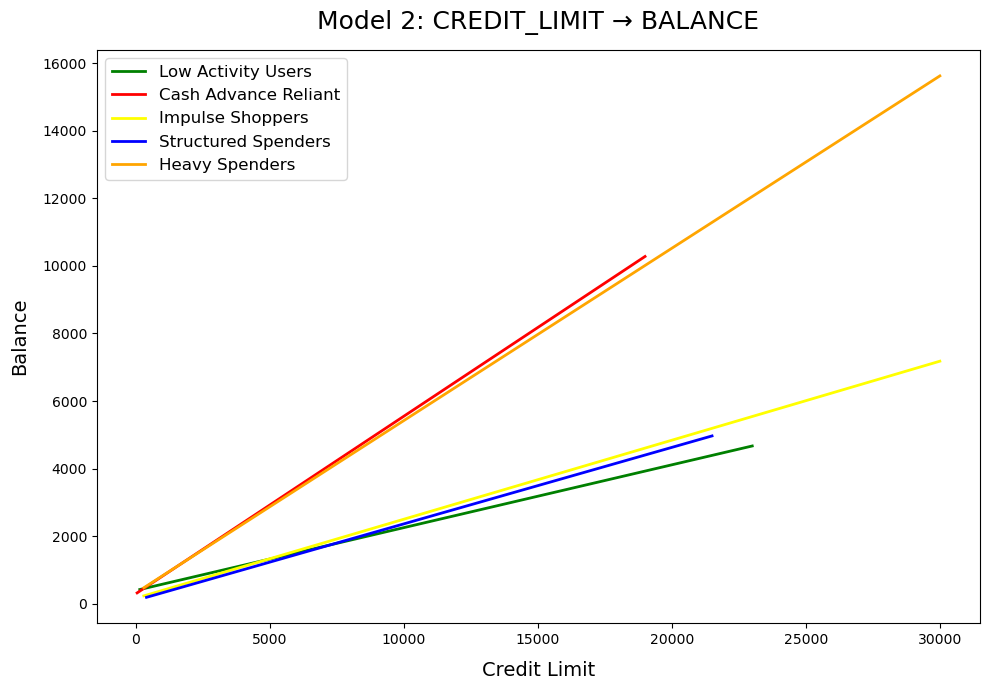

In [48]:
colors = {
    "Low Activity Users": "green",
    "Structured Spenders": "blue",
    "Impulse Shoppers": "yellow",
    "Cash Advance Reliant": "red",
    "Heavy Spenders": "orange"
}

plt.figure(figsize=(10, 7))

for cluster in df["Cluster_Label"].unique():
    cluster_data = df[df["Cluster_Label"] == cluster]

    # Fit regression line
    X = cluster_data[["CREDIT_LIMIT"]]
    y = cluster_data["BALANCE"]
    model = LinearRegression().fit(X, y)

    # Generate smooth x-range
    x_min, x_max = X.min()[0], X.max()[0]
    x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
    y_pred = model.predict(x_range)

    # Plot regression line only
    plt.plot(x_range, y_pred, color=colors[cluster], linewidth=2, label=cluster)

plt.title("Model 2: CREDIT_LIMIT → BALANCE", fontsize=18, pad=15)
plt.xlabel("Credit Limit", fontsize=14, labelpad=10)
plt.ylabel("Balance", fontsize=14, labelpad=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

As we can see, the Cash Advance Reliant and Heavy Spenders clusters had a stronger relationship between their credit limit and balance. This indicates that these groups are more likely to utilize close to all of their credit and rack up a large balance.

c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


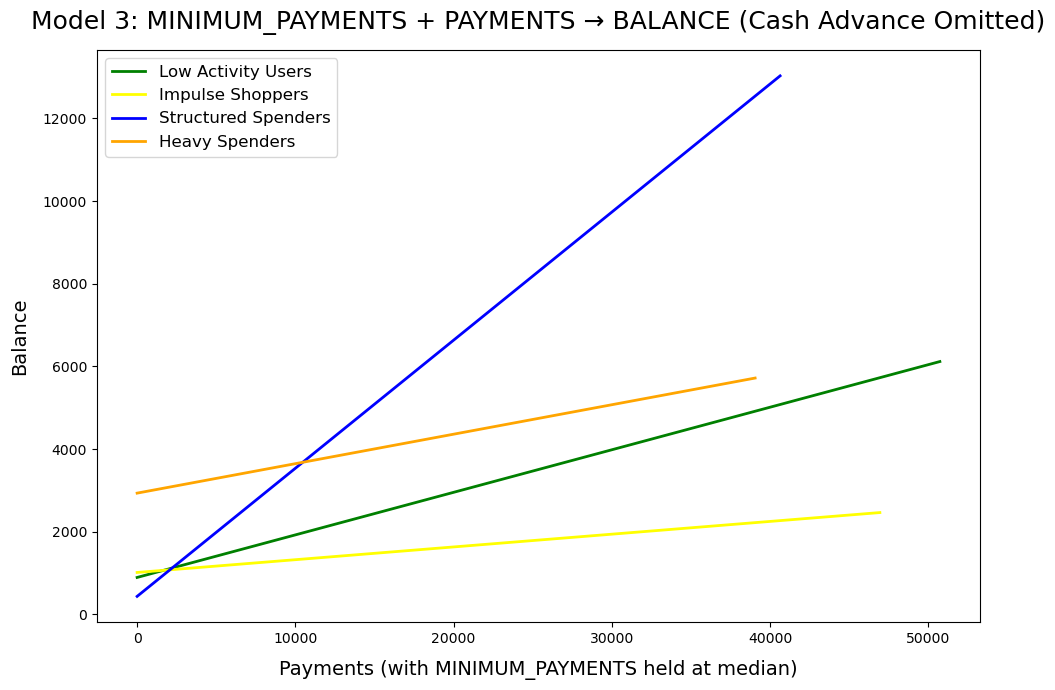

In [50]:
plt.figure(figsize=(10, 7))

for cluster in df["Cluster_Label"].unique():

    # Omit Cash Advance Reliant from Model 3 visualization
    if cluster == "Cash Advance Reliant":
        continue

    cluster_data = df[df["Cluster_Label"] == cluster]

    # Fit regression model using both features
    X = cluster_data[["MINIMUM_PAYMENTS", "PAYMENTS"]]
    y = cluster_data["BALANCE"]
    model = LinearRegression().fit(X, y)

    # Create regression line (hold MINIMUM_PAYMENTS constant at median)
    minpay_median = cluster_data["MINIMUM_PAYMENTS"].median()
    payments_range = np.linspace(cluster_data["PAYMENTS"].min(),
                                 cluster_data["PAYMENTS"].max(), 100)

    X_line = np.column_stack([
        np.full_like(payments_range, minpay_median),
        payments_range
    ])
    y_pred = model.predict(X_line)

    # Plot only the regression line
    plt.plot(payments_range, y_pred, color=colors[cluster], linewidth=2, label=cluster)

plt.title("Model 3: MINIMUM_PAYMENTS + PAYMENTS → BALANCE (Cash Advance Omitted)", fontsize=18, pad=15)
plt.xlabel("Payments (with MINIMUM_PAYMENTS held at median)", fontsize=14, labelpad=10)
plt.ylabel("Balance", fontsize=14, labelpad=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

We hold MINIMUM_PAYMENTS at the median so that our x-axis represents how much beyond their minimum a customer is paying back, rather than just the payments they are making in isolation. This gives us more accurate and contextually meaningful behavioral data.

Something to note is that payments beyond the minimum had a high correlation with balance for Structured Spenders. This is in line with what is expected, given the installment-based nature of the expenditures of this group. Something else to note is that for Heavy Spenders and Impulse Shoppers, the positive trend is much weaker.

This shows us that some individuals in these two groups are financially responsible and try to pay off their balances quickly, while others let their debt accumulate and have to adjust with high payments later.

This indicates an inconsistent level of financial responsibility within these two groups.

____________________________________________________________________________________________________________________________________________________

Conclusion

Our analysis grouped customers into five spending behavior clusters and revealed clear financial differences between them. Structured Spenders showed consistent and responsible repayment habits, while Heavy Spenders and Impulse Shoppers had similar spending intensity but far more variable repayment patterns. Cash Advance Reliant users demonstrated the highest financial risk, with balances and payments showing no stable relationship. 

Overall, repayment discipline is strongly tied to spending style: some groups manage debt predictably, while others display inconsistent or high-risk credit behavior.

____________________________________________________________________________________________________________________________________________________

Limitations & Considerations

Our one major limitation was the unpredictability of the spending habits of the five spending groups. The low R2 scores indicate that while our linear regression models reveal general relationships between features, the actual data points are scattered enough that relying on the trendlines alone is not reliable.

This means that while our linear regression models help visualize positive relationships between variables, they do not perform well as predictive models by themselves.